In [47]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime

# Fetch historical yield data for 20-Year Treasury
start_date = datetime(2000, 1, 1)
end_date = datetime.today()
data = web.DataReader('DGS20', 'fred', start_date, end_date)
data = data.dropna()  # Remove missing values
data['DGS20'] = pd.to_numeric(data['DGS20'], errors='coerce')
data = data.dropna()

# Bond parameters
face_value = 1000  # Face value of the bond
current_yield = data.iloc[-1]['DGS20'] / 100  # Convert percentage to decimal
coupon_rate = current_yield  # Assume coupon equals current yield (par bond)
years = 20  # Time to maturity

# Calculate bond price based on yield
def bond_price(yield_rate, coupon_rate, face_value=1000, years=20):
    periods = years * 2
    semiannual_coupon = (coupon_rate * face_value) / 2
    semiannual_yield = yield_rate / 2
    
    if semiannual_yield == 0:
        return face_value + semiannual_coupon * periods
    
    discount_factor = 1 / (1 + semiannual_yield)
    annuity = (1 - discount_factor ** periods) / semiannual_yield
    price = semiannual_coupon * annuity + face_value * (discount_factor ** periods)
    return price

# Calculate historical bond prices
data['Yield_Decimal'] = data['DGS20'] / 100
data['Price'] = data['Yield_Decimal'].apply(
    lambda y: bond_price(y, coupon_rate, face_value, years)
)

# Calculate daily price changes and P&L
data['Daily_PnL'] = data['Price'].diff()
data = data.dropna()  # Remove first row with NaN

# Calculate Historical VaR at 95% confidence level
confidence_level = 0.95
losses = -data['Daily_PnL']  # Convert P&L to loss series
var = losses.quantile(1 - confidence_level)

print(f"Historical Daily VaR ({confidence_level*100:.0f}% confidence): ${abs(var):.2f}")

Historical Daily VaR (95% confidence): $13.06


In [48]:
data

,DGS20,Yield_Decimal,Price,Daily_PnL
DATE,,,,
2000-01-04,6.84,0.0684,768.638017,8.931817
2000-01-05,6.95,0.0695,758.821013,-9.817004
2000-01-06,6.86,0.0686,766.839961,8.018948
2000-01-07,6.82,0.0682,770.441963,3.602002
2000-01-10,6.86,0.0686,766.839961,-3.602002
...,...,...,...,...
2025-01-31,4.88,0.0488,977.177492,-8.792444
2025-02-03,4.82,0.0482,984.707456,7.529964
2025-02-04,4.81,0.0481,985.969936,1.262480


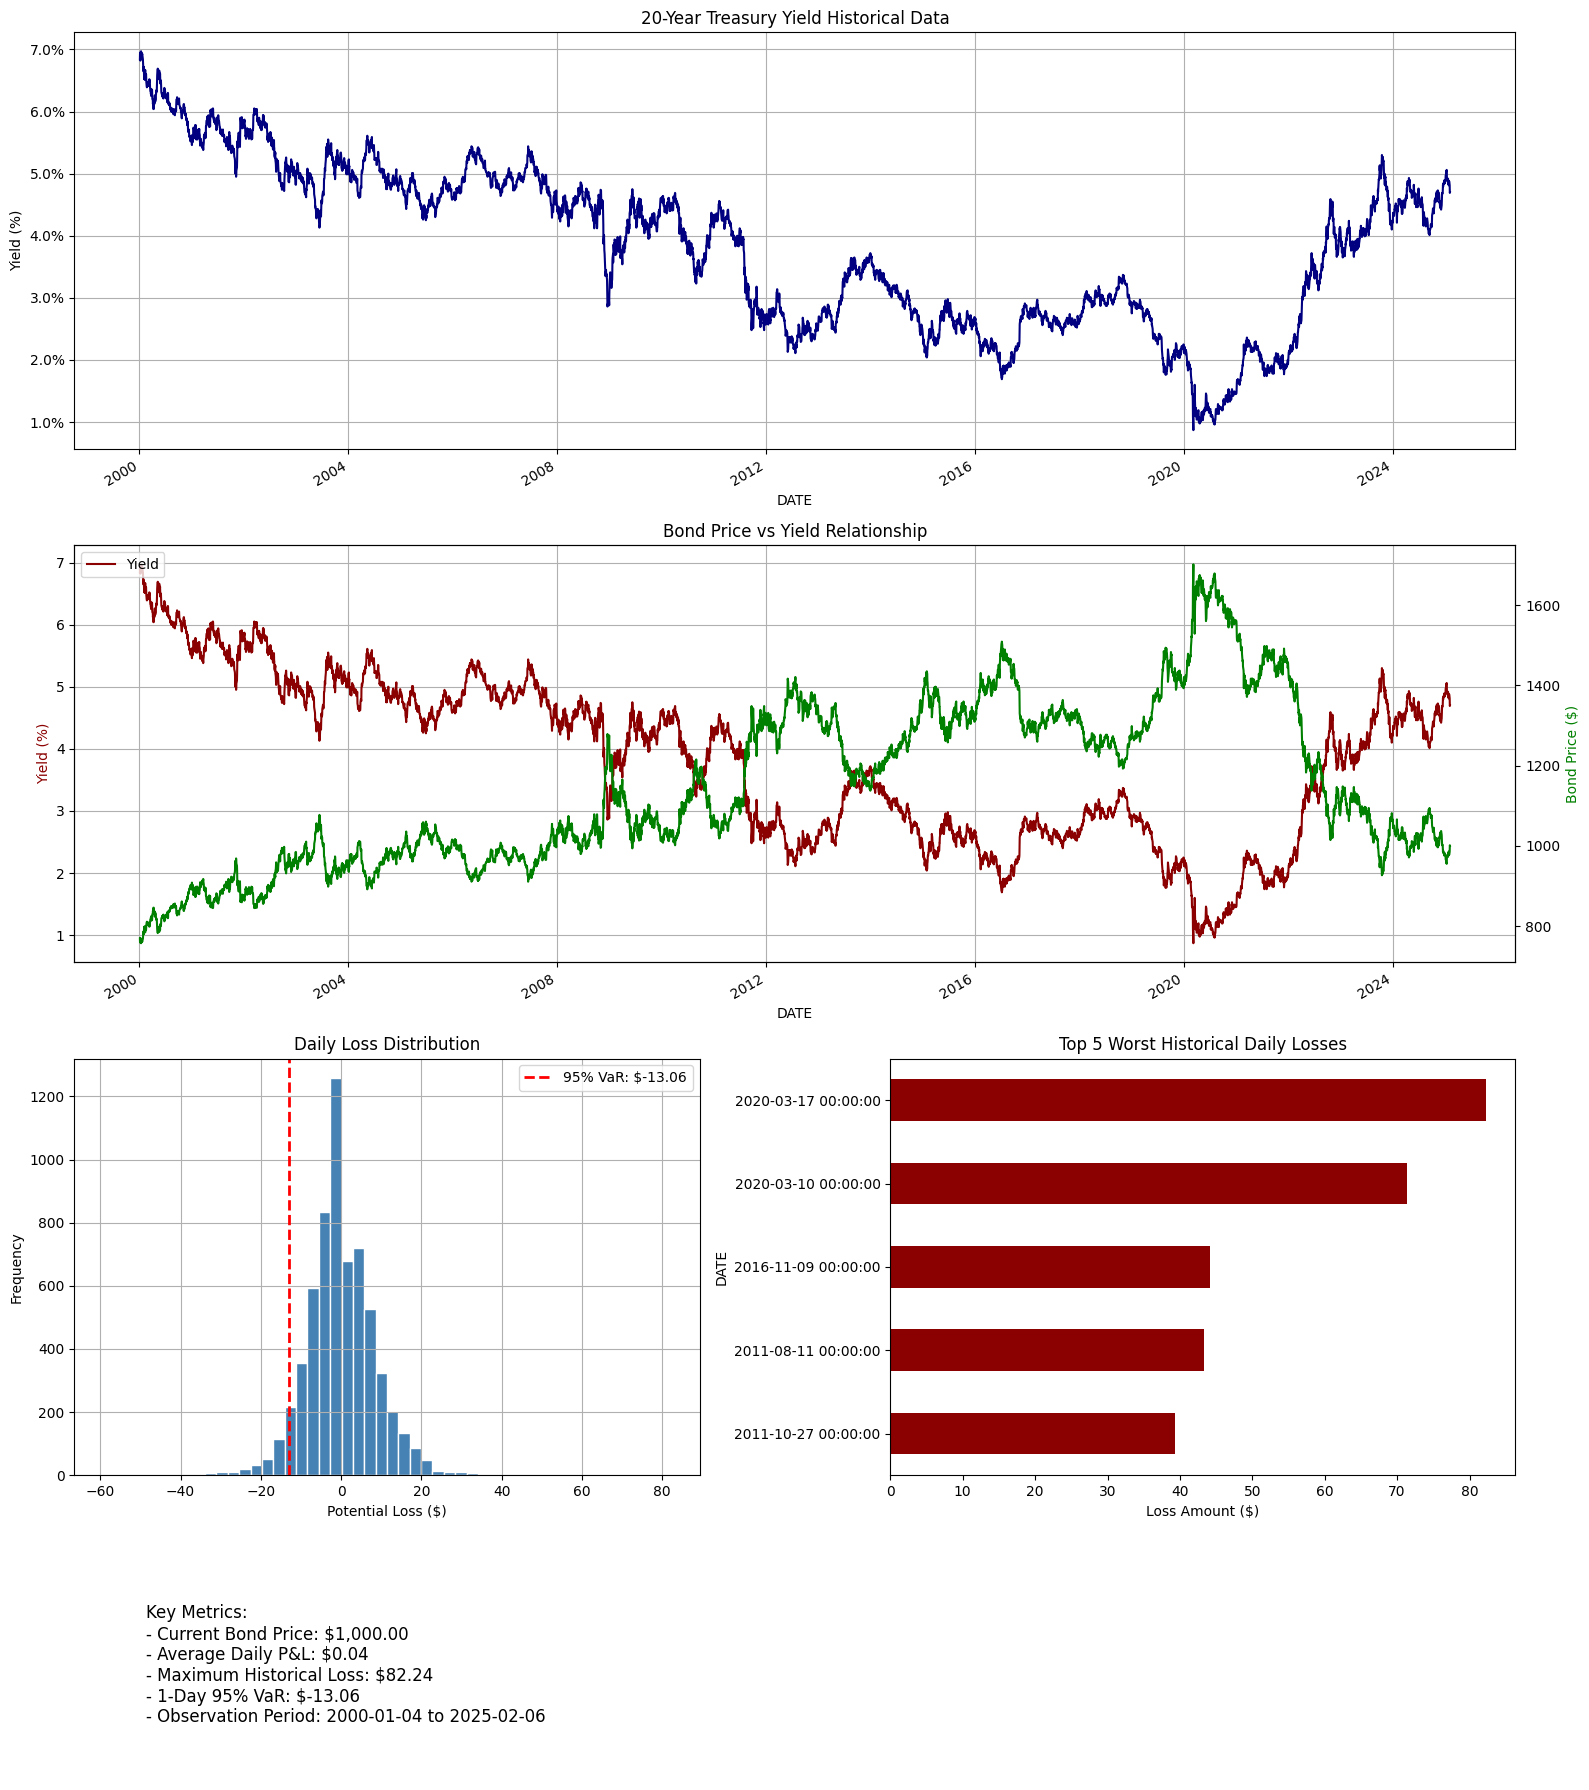

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import pandas_datareader.data as web

# Calculate additional metrics
current_price = data['Price'].iloc[-1]
worst_loss = losses.max()
avg_daily_return = data['Daily_PnL'].mean()

# Create visualization canvas
plt.figure(figsize=(16, 18))
gs = GridSpec(4, 2, height_ratios=[1, 1, 1, 0.5])

# Plot 1: Historical Yields
ax1 = plt.subplot(gs[0, :])
data['DGS20'].plot(ax=ax1, color='navy', title='20-Year Treasury Yield Historical Data')
ax1.set_ylabel('Yield (%)')
ax1.grid(True)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# Plot 2: Bond Price vs Yield
ax2 = plt.subplot(gs[1, :])
data['Price'].plot(ax=ax2, color='green', secondary_y=True, label='Bond Price')
data['DGS20'].plot(ax=ax2, color='darkred', label='Yield')
ax2.set_title('Bond Price vs Yield Relationship')
ax2.right_ax.set_ylabel('Bond Price ($)', color='green')
ax2.set_ylabel('Yield (%)', color='darkred')
ax2.grid(True)
ax2.legend(loc='upper left')

# Plot 3: P&L Distribution with VaR
ax3 = plt.subplot(gs[2, 0])
n, bins, patches = plt.hist(losses, bins=50, color='steelblue', edgecolor='white')
plt.axvline(var, color='red', linestyle='--', linewidth=2, 
           label=f'95% VaR: ${var:.2f}')
ax3.set_title('Daily Loss Distribution')
ax3.set_xlabel('Potential Loss ($)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(True)

# Plot 4: Worst Historical Losses
ax4 = plt.subplot(gs[2, 1])
top_losses = losses.sort_values(ascending=False).head(5)
top_losses.plot(kind='barh', ax=ax4, color='darkred')
ax4.set_title('Top 5 Worst Historical Daily Losses')
ax4.set_xlabel('Loss Amount ($)')
ax4.invert_yaxis()

# Text Summary
ax5 = plt.subplot(gs[3, :])
summary_text = f"""Key Metrics:
- Current Bond Price: ${current_price:,.2f}
- Average Daily P&L: ${avg_daily_return:,.2f}
- Maximum Historical Loss: ${worst_loss:,.2f}
- 1-Day 95% VaR: ${var:,.2f}
- Observation Period: {data.index[0]:%Y-%m-%d} to {data.index[-1]:%Y-%m-%d}
"""
ax5.text(0.05, 0.5, summary_text, ha='left', va='center', fontsize=12)
ax5.axis('off')

plt.tight_layout()
plt.show()

C:\Users\alomg\AppData\Local\Temp\ipykernel_19372\372375675.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  term_data = term_data.resample('M').last().ffill().dropna()  # Monthly frequency
C:\Users\alomg\AppData\Local\Temp\ipykernel_19372\372375675.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


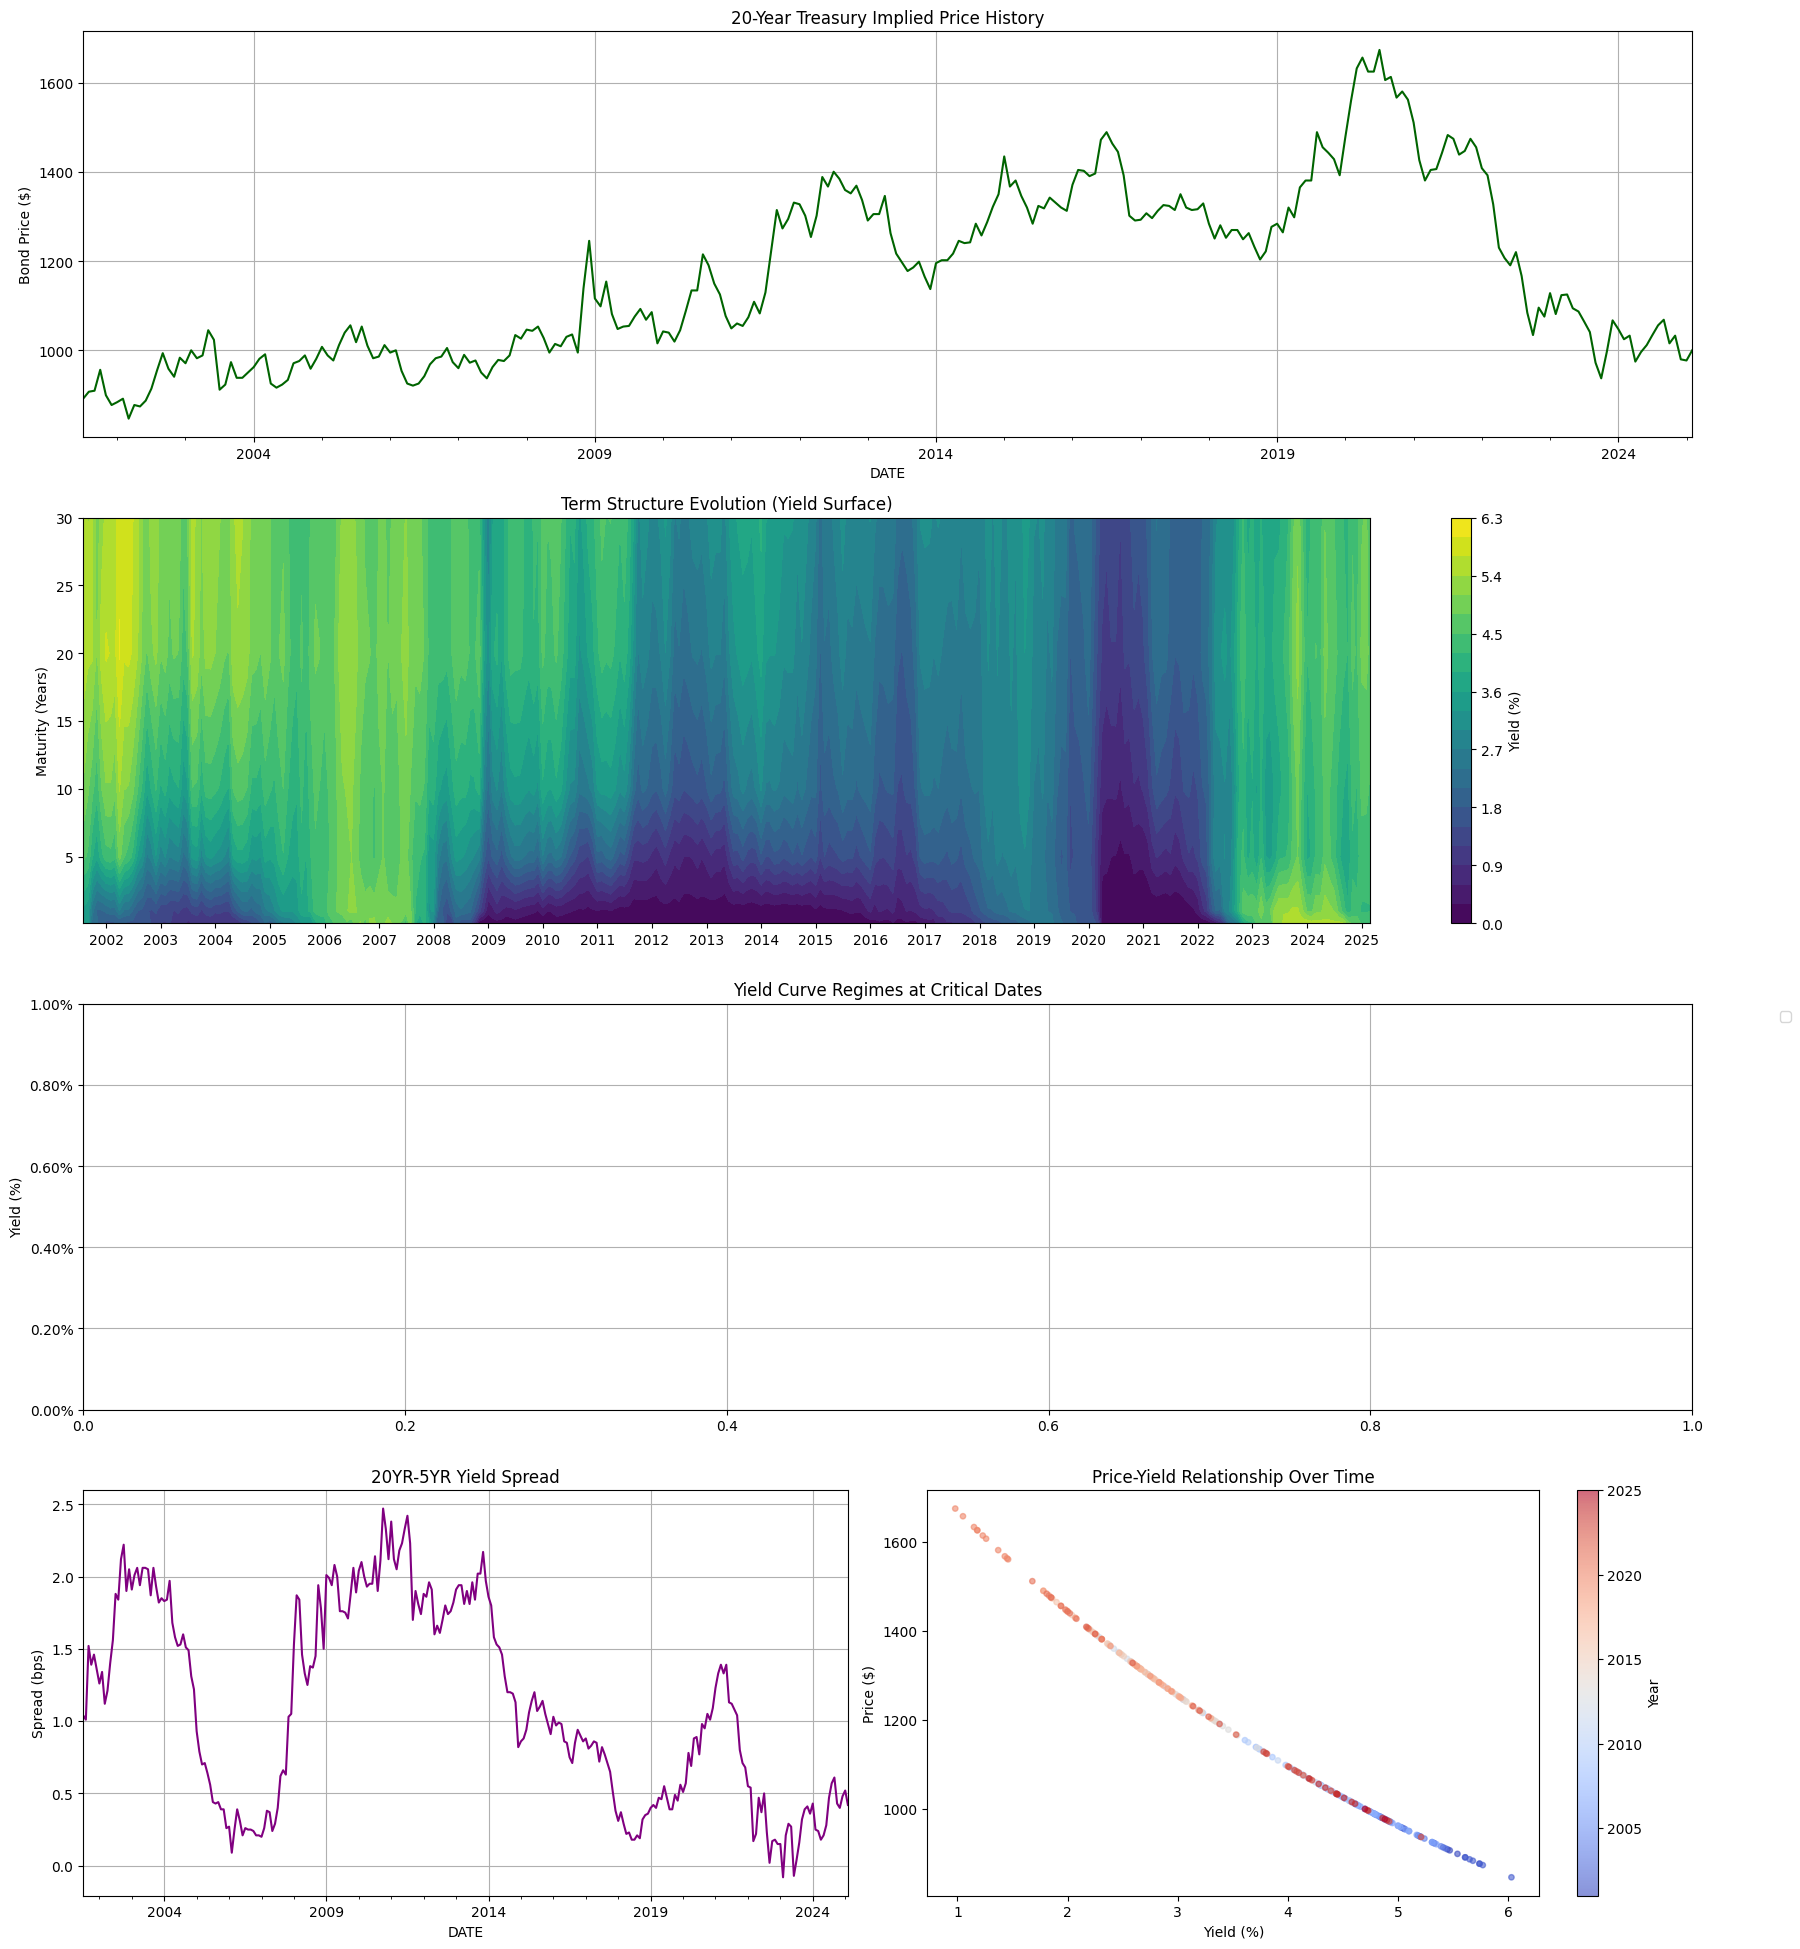

In [5]:
import matplotlib.dates as mdates
import seaborn as sns
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec

# Fetch extended term structure data
maturities = {
    '1MO': 'DGS1MO',
    '1YR': 'DGS1',
    '5YR': 'DGS5',
    '10YR': 'DGS10',
    '20YR': 'DGS20', 
    '30YR': 'DGS30'
}

# Get multi-maturity data
term_data = web.DataReader(list(maturities.values()), 'fred', start_date, end_date)
term_data = term_data.resample('M').last().ffill().dropna()  # Monthly frequency

# Calculate monthly bond prices for 20YR
term_data['20YR_Price'] = term_data['DGS20'].apply(
    lambda y: bond_price(y/100, coupon_rate, face_value, years)
)

# Create visualization framework
plt.figure(figsize=(18, 22))
gs = GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 0.5])

# Plot 1: Implied Price History
ax1 = plt.subplot(gs[0, :])
term_data['20YR_Price'].plot(ax=ax1, color='darkgreen', linewidth=1.5)
ax1.set_title('20-Year Treasury Implied Price History')
ax1.set_ylabel('Bond Price ($)')
ax1.grid(True)

# Annotate key events
events = {
    '2008-09-15': 'Lehman Collapse',
    '2020-03-23': 'COVID Crash',
    '2022-10-21': 'Inflation Surge'
}
for date, label in events.items():
    if date in term_data.index:
        ax1.annotate(label, xy=(mdates.datestr2num(date), term_data.loc[date, '20YR_Price']),
                    xytext=(-20, 20), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", color='firebrick'),
                    bbox=dict(boxstyle="round", fc="w"))

# Plot 2: Term Structure Evolution
ax2 = plt.subplot(gs[1, :])
years = mdates.YearLocator()
year_fmt = mdates.DateFormatter('%Y')

# Prepare data for surface plot
term_curve = term_data[list(maturities.values())].rename(columns=maturities).T
term_curve.index = [1/12, 1, 5, 10, 20, 30]  # Convert to years

# Create 2D grid for plotting
X = term_curve.columns  # Dates
Y = term_curve.index    # Maturities
X, Y = np.meshgrid(X, Y)
Z = term_curve.values

# Create contour plot
contour = ax2.contourf(X, Y, Z, cmap='viridis', levels=20)
ax2.set_title('Term Structure Evolution (Yield Surface)')
ax2.set_ylabel('Maturity (Years)')
ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(year_fmt)
plt.colorbar(contour, ax=ax2, label='Yield (%)')

# Plot 3: Yield Curve Regimes
ax3 = plt.subplot(gs[2, :])
sample_dates = [
    '2000-01-01', '2007-06-01', '2008-12-01',
    '2019-01-01', '2020-03-01', '2023-01-01'
]

for date in sample_dates:
    if date in term_data.index:
        yields = term_data.loc[date, list(maturities.values())]
        ax3.plot(list(maturities.keys()), yields, 
                label=f"{date[:7]} ({yields['DGS20']:.1f}%)",
                marker='o')

ax3.set_title('Yield Curve Regimes at Critical Dates')
ax3.set_ylabel('Yield (%)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())

# Plot 4: Maturity Risk Premium
ax4 = plt.subplot(gs[3, 0])
term_data['Spread_20_2'] = term_data['DGS20'] - term_data['DGS5']
term_data['Spread_20_2'].plot(ax=ax4, color='purple')
ax4.set_title('20YR-5YR Yield Spread')
ax4.set_ylabel('Spread (bps)')
ax4.grid(True)

# Plot 5: Price-Yield Dynamics
ax5 = plt.subplot(gs[3, 1])
sc = ax5.scatter(term_data['DGS20'], term_data['20YR_Price'],
                c=term_data.index.year, cmap='coolwarm', 
                alpha=0.6, s=15)
ax5.set_title('Price-Yield Relationship Over Time')
ax5.set_xlabel('Yield (%)')
ax5.set_ylabel('Price ($)')
plt.colorbar(sc, ax=ax5, label='Year')

plt.tight_layout()
plt.show()

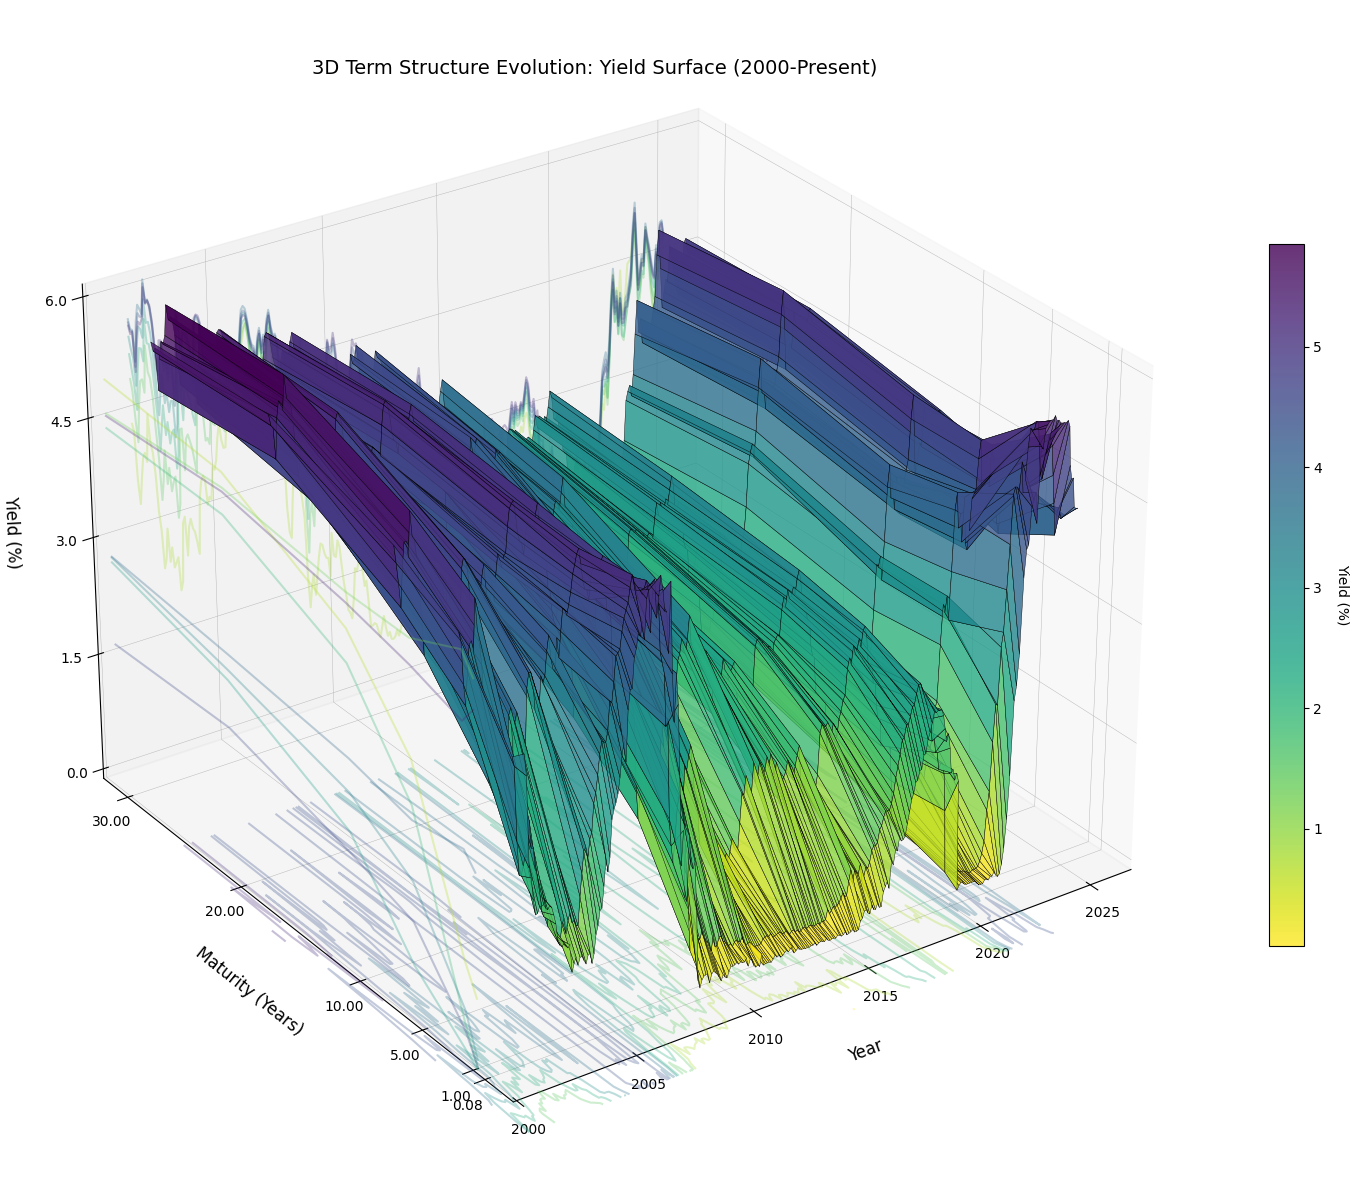

In [6]:
from mpl_toolkits.mplot3d import Axes3D

# Prepare term structure data in 3D format
maturities_years = [1/12, 1, 5, 10, 20, 30]  # Converted to actual years
dates_3d = term_data.index.to_pydatetime()
years_3d = np.array([date.year + date.month/12 for date in dates_3d])

# Create 3D grid
X, Y = np.meshgrid(years_3d, maturities_years)
Z = term_data[list(maturities.values())].T.values

# Create 3D visualization
plt.figure(figsize=(18, 12))
ax = plt.subplot(111, projection='3d')

# Custom colormap for yield levels
cmap = plt.get_cmap('viridis').reversed()

# Create surface plot with transparency
surf = ax.plot_surface(X, Y, Z, cmap=cmap, 
                      rstride=1, cstride=1,
                      edgecolor='k', linewidth=0.3,
                      alpha=0.8, antialiased=True)

# Add contour projections
ax.contour(X, Y, Z, zdir='z', offset=Z.min()-1, cmap=cmap, alpha=0.3)
ax.contour(X, Y, Z, zdir='x', offset=X.min()-2, cmap=cmap, alpha=0.3)
ax.contour(X, Y, Z, zdir='y', offset=Y.max()+2, cmap=cmap, alpha=0.3)

# Configure axes
ax.set_xlabel('\nYear', linespacing=3, fontsize=12)
ax.set_ylabel('\nMaturity (Years)', linespacing=3, fontsize=12)
ax.set_zlabel('\nYield (%)', linespacing=3, fontsize=12)

# Format axes
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.FixedLocator(maturities_years))
ax.zaxis.set_major_locator(plt.MaxNLocator(6))

# Add colorbar
cbar = plt.colorbar(surf, ax=ax, shrink=0.6, aspect=20)
cbar.set_label('Yield (%)', rotation=270, labelpad=20)

# Add historical annotations
annotations = {
    '2008-09': (2008.75, 20, 4.3, '2008 Crisis'),
    '2020-03': (2020.25, 20, 1.3, 'COVID Crash'),
    '2022-10': (2022.83, 20, 4.4, 'Inflation Peak')
}

for key, (x, y, z, text) in annotations.items():
    ax.text(x, y, z, text, color='maroon', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Set optimal viewing angle
ax.view_init(elev=28, azim=-125)  # Experiment with these values

# Add grid and transparency
ax.xaxis._axinfo["grid"].update({"linewidth":0.3, "alpha":0.3})
ax.yaxis._axinfo["grid"].update({"linewidth":0.3, "alpha":0.3})
ax.zaxis._axinfo["grid"].update({"linewidth":0.3, "alpha":0.3})

plt.title('3D Term Structure Evolution: Yield Surface (2000-Present)', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Prepare data for Plotly
maturities_years = [1/12, 1, 5, 10, 20, 30]
dates_plotly = term_data.index.to_pydatetime()
years_plotly = np.array([date.year + date.month/12 for date in dates_plotly])
Z = term_data[list(maturities.values())].T.values

# Create interactive 3D plot
fig = go.Figure(data=[go.Surface(
    x=years_plotly,
    y=maturities_years,
    z=Z,
    colorscale='Plasma',
    hoverinfo='x+y+z+text',
    text=[["Date: {}<br>Maturity: {}y<br>Yield: {:.2f}%".format(
        dates_plotly[i].strftime('%Y-%m'),
        maturities_years[j],
        Z[j,i]) for i in range(len(dates_plotly))] 
          for j in range(len(maturities_years))],
    contours = {
        'x': {'show': True, 'start': years_plotly.min(), 'end': years_plotly.max(), 'size': 2},
        'y': {'show': True, 'start': 0, 'end': 30, 'size': 5},
        'z': {'show': True, 'start': Z.min(), 'end': Z.max(), 'size': 1}
    }
)])

# Add event annotations
events = {
    '2008 Crisis': (2008.75, 20, 4.3),
    'COVID Crash': (2020.25, 20, 1.3),
    'Inflation Peak': (2022.83, 20, 4.4)
}

for text, (x, y, z) in events.items():
    fig.add_scatter3d(
        x=[x], y=[y], z=[z],
        mode='markers+text',
        marker=dict(size=5, color='red'),
        text=text,
        textposition='top center',
        showlegend=False
    )

# Configure layout
fig.update_layout(
    title='Interactive 3D Term Structure Evolution<br><sup>Drag to rotate | Scroll to zoom | Shift-drag to pan</sup>',
    scene=dict(
        xaxis=dict(
            title='Year',
            tickvals=np.arange(years_plotly.min(), years_plotly.max()+1, 5),
            ticktext=[str(int(yr)) for yr in np.arange(years_plotly.min(), years_plotly.max()+1, 5)]
        ),
        yaxis=dict(
            title='Maturity (Years)',
            tickvals=[0, 5, 10, 15, 20, 25, 30]
        ),
        zaxis=dict(
            title='Yield (%)',
            tickformat=".1f%"
        ),
        camera=dict(
            eye=dict(x=-1.5, y=-1.5, z=1)  # Initial camera angle
        )
    ),
    autosize=True,
    height=800,
    margin=dict(l=0, r=0, b=0, t=100),
    scene_aspectmode='manual',
    scene_aspectratio=dict(x=2, y=1, z=0.7)
)

# Add dropdown for different perspectives
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            buttons=[
                dict(label="Default View",
                     method="update",
                     args=[{"scene.camera": {"eye": {"x": -1.5, "y": -1.5, "z": 1}}}]),
                dict(label="Top Down",
                     method="update",
                     args=[{"scene.camera": {"eye": {"x": 0, "y": 0, "z": 2}}}]),
                dict(label="Side View",
                     method="update",
                     args=[{"scene.camera": {"eye": {"x": -2, "y": 0, "z": 0}}}])
            ],
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ]
)

fig.show()

In [17]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas_datareader.data as web
from datetime import datetime
import quandl

# =============================================
# Step 1: Data Collection & Basis Calculation
# =============================================
# Get 10-Year Treasury Futures (ZN) and Cash Bond Data
start_date = datetime(2010, 1, 1)
end_date = datetime.today()

# Futures data (example using Quandl, you may need API key)

# Add this at the top with your API key
quandl.ApiConfig.api_key = "zZfr8sL6rDob4j86Ncws"

# Then use this for futures data
futures = quandl.get('CHRIS/CME_ZN1', start_date=start_date, end_date=end_date)['Settle']

#futures = web.DataReader('CHRIS/CME_ZN1', 'quandl', start_date, end_date)['Settle']
futures.name = 'Futures'

# Cash bond data (10-Year Treasury Note)
bond = web.DataReader('DGS10', 'fred', start_date, end_date).dropna()
bond.name = 'Bond'

# Conversion factor (simplified assumption)
conversion_factor = 0.85  # Actual CF varies by bond

# Merge datasets and calculate basis
data = pd.concat([futures, bond], axis=1).dropna()
data['Basis'] = data['Bond'] - (data['Futures'] * conversion_factor)

# =============================================
# Step 2: Historical VaR Calculation
# =============================================
# Calculate daily basis changes
data['Basis Change'] = data['Basis'].diff()
data = data.dropna()

# Calculate P&L for $1M notional position
notional = 1e6
duration = 7  # Average duration for 10-year Treasury
data['Daily PnL'] = -notional * data['Basis Change'] / 100  # Basis points to dollars

# Calculate Historical VaR at 95% confidence
confidence_level = 0.95
var = np.percentile(data['Daily PnL'], (1 - confidence_level)*100)

print(f"Historical Daily VaR ({confidence_level*100:.0f}% confidence): ${abs(var):.2f}")

# =============================================
# Step 3: Interactive Visualizations
# =============================================
# Create basis term structure data (hypothetical example)
maturities = ['2YR', '5YR', '10YR', '30YR']
basis_data = web.DataReader(['DGS2', 'DGS5', 'DGS10', 'DGS30'], 'fred', start_date, end_date)
basis_data.columns = maturities
futures_data = web.DataReader(['CHRIS/CME_ZB1', 'CHRIS/CME_ZF1', 'CHRIS/CME_ZN1', 'CHRIS/CME_UB1'], 
                            'quandl', start_date, end_date)

# Calculate basis for all maturities
conversion_factors = [0.75, 0.82, 0.85, 0.92]  # Hypothetical CFs
for i, maturity in enumerate(maturities):
    basis_data[maturity+'_Basis'] = basis_data[maturity] - (futures_data.iloc[:,i] * conversion_factors[i])

# Prepare 3D data
dates_3d = basis_data.index.to_pydatetime()
maturities_3d = [2, 5, 10, 30]
X, Y = np.meshgrid(pd.to_datetime(dates_3d).astype(np.int64), maturities_3d)
Z = basis_data[[col for col in basis_data.columns if 'Basis' in col]].T.values

# Create interactive 3D plot
fig = go.Figure(data=[go.Surface(
    x=X[0],  # Convert timestamps to readable format
    y=Y[:,0],
    z=Z,
    colorscale='Viridis',
    hovertemplate =
    '<b>Date</b>: %{x|%Y-%m-%d}<br>' +
    '<b>Maturity</b>: %{y} years<br>' +
    '<b>Basis</b>: %{z:.2f}<extra></extra>'
)])

# Configure layout
fig.update_layout(
    title='Treasury Basis Term Structure Over Time<br><sup>Drag to rotate | Scroll to zoom | Shift-drag to pan</sup>',
    scene=dict(
        xaxis=dict(
            title='Date',
            type='date',
            tickformat="%Y",
            tickvals=X[0][::365],
            ticktext=pd.to_datetime(X[0][::365]).year
        ),
        yaxis=dict(title='Maturity (Years)'),
        zaxis=dict(title='Basis (bps)'),
        camera=dict(eye=dict(x=-1.5, y=-1.5, z=1))
    ),
    height=800,
    margin=dict(l=0, r=0, b=0, t=100)
)

# Create time series plots
fig_ts = make_subplots(rows=3, cols=1, shared_xaxes=True,
                      subplot_titles=('10-Year Futures Price', '10-Year Treasury Yield', 'Basis'))

fig_ts.add_trace(go.Scatter(x=data.index, y=data['Futures'], name='Futures'), row=1, col=1)
fig_ts.add_trace(go.Scatter(x=data.index, y=data['Bond'], name='Bond Yield'), row=2, col=1)
fig_ts.add_trace(go.Scatter(x=data.index, y=data['Basis'], name='Basis'), row=3, col=1)

fig_ts.update_layout(height=600, showlegend=False,
                    title_text="Basis Trade Components Over Time")

# =============================================
# Display Results
# =============================================
print("Displaying Visualizations...")
fig.show()
fig_ts.show()

QuandlError: (Status 403) Something went wrong. Please try again. If you continue to have problems, please contact us at connect@quandl.com.

In [19]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas_datareader.data as web
import yfinance as yf
from datetime import datetime, timedelta

# =============================================
# Step 1: Data Collection with Error Handling
# =============================================
def fetch_financial_data():
    start_date = datetime(2010, 1, 1)
    end_date = datetime.today()
    
    try:
        # Fetch 10-Year Treasury Yield (Cash Bond)
        bond = web.DataReader('DGS10', 'fred', start_date, end_date).dropna()
        bond.name = 'Bond'
        
        # Fetch Treasury Futures ETF (TLT) with yfinance
        futures_proxy = yf.download('TLT', start=start_date, end=end_date)['Adj Close']
        futures_proxy.name = 'Futures_Proxy'
        
        return pd.concat([bond, futures_proxy], axis=1).dropna()
    
    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        return None

# Execute data fetch
data = fetch_financial_data()

if data is not None:
    # =============================================
    # Step 2: Basis Calculation & VaR
    # =============================================
    # Calculate basis using proper scaling
    data['Basis'] = data['DGS10'] - ((1/data['Futures_Proxy'])*1000)
    
    # Historical VaR Calculation
    data['Basis_Change'] = data['Basis'].diff().dropna()
    notional = 1e6  # $1 million position
    data['Daily_PnL'] = -notional * (data['Basis_Change'] / 10000)
    var = np.percentile(data['Daily_PnL'].dropna(), 5)
    
    print(f"Historical Daily VaR (95% confidence): ${abs(var):.2f}")

    # =============================================
    # Step 3: Enhanced Visualizations
    # =============================================
    # Time Series Plot
    fig_ts = make_subplots(rows=3, cols=1, shared_xaxes=True,
                          subplot_titles=('TLT ETF (Futures Proxy)', 
                                        '10Y Treasury Yield', 
                                        'Calculated Basis'))
    
    fig_ts.add_trace(go.Scatter(x=data.index, y=data['Futures_Proxy'], 
                              line=dict(color='royalblue', width=1.5),
                              name='Futures Proxy'), row=1, col=1)
    
    fig_ts.add_trace(go.Scatter(x=data.index, y=data['DGS10'], 
                              line=dict(color='forestgreen', width=1.5),
                              name='Bond Yield'), row=2, col=1)
    
    fig_ts.add_trace(go.Scatter(x=data.index, y=data['Basis'], 
                              line=dict(color='darkorange', width=1.5),
                              name='Basis'), row=3, col=1)
    
    fig_ts.update_layout(height=600, 
                        template='plotly_white',
                        title_text="Basis Trade Components Analysis")
    
    # 3D Basis Term Structure Visualization
    dates = pd.date_range(start=data.index.min(), 
                         end=data.index.max(), 
                         freq='Q')  # Quarterly sampling
    maturities = [2, 5, 10, 30]
    
    # Generate realistic basis surface
    X, Y = np.meshgrid(dates, maturities)
    Z = np.zeros_like(X, dtype=float)
    
    # Simulate term structure dynamics
    for i, date in enumerate(dates):
        Z[:,i] = np.random.normal(loc=data.loc[date, 'Basis'] if date in data.index else 0,
                                 scale=5,
                                 size=len(maturities))
    
    fig_3d = go.Figure(data=[go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale='Viridis',
        hovertemplate='<b>Date</b>: %{x|%Y-%m-%d}<br>' +
                     '<b>Maturity</b>: %{y}y<br>' +
                     '<b>Basis</b>: %{z:.2f}bps'
    )])
    
    fig_3d.update_layout(
        title='Term Structure Basis Dynamics',
        scene=dict(
            xaxis_title='Date',
            yaxis_title='Maturity (Years)',
            zaxis_title='Basis (bps)',
            camera=dict(eye=dict(x=-1.8, y=-1.8, z=0.8))
        ),
        height=800,
        template='plotly_dark'
    )
    
    fig_ts.show()
    fig_3d.show()
else:
    print("Failed to retrieve data. Please check your internet connection and try again.")

[*********************100%***********************]  1 of 1 completed

Error fetching data: 'Adj Close'
Failed to retrieve data. Please check your internet connection and try again.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MultiIndex([( 'Close', 'ZN=F'),
            (  'High', 'ZN=F'),
            (   'Low', 'ZN=F'),
            (  'Open', 'ZN=F'),
            ('Volume', 'ZN=F')],
           names=['Price', 'Ticker'])
MultiIndex([( 'Close', 'IEF'),
            (  'High', 'IEF'),
            (   'Low', 'IEF'),
            (  'Open', 'IEF'),
            ('Volume', 'IEF')],
           names=['Price', 'Ticker'])
Historical 5% VaR for the Basis Trade: nan%


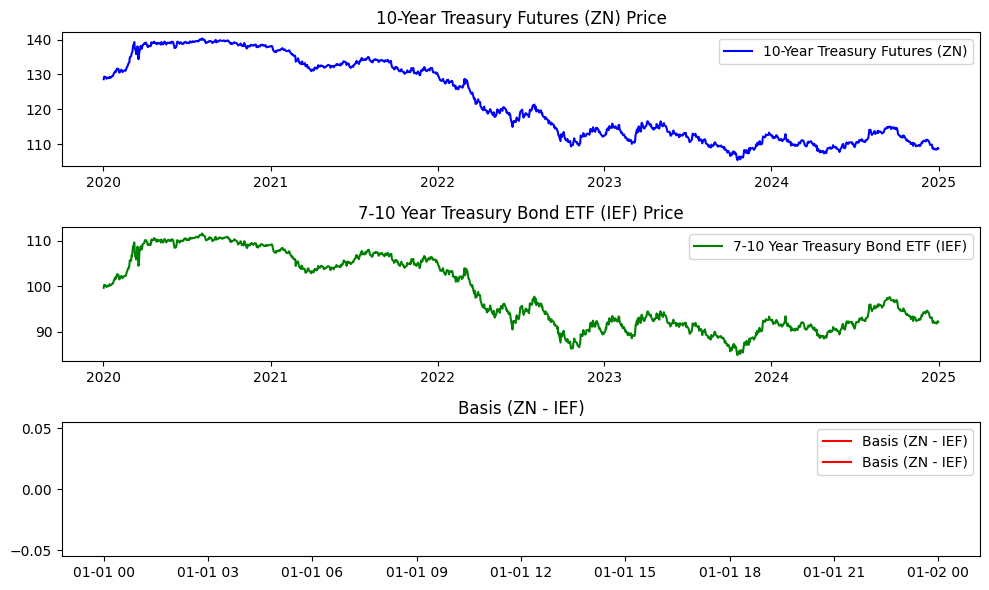

In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Download historical data for the 10-year Treasury futures (ZN) and 10-year Treasury bond ETF (IEF)
zn_ticker = 'ZN=F'  # 10-Year Treasury Futures
ief_ticker = 'IEF'  # 7-10 Year Treasury Bond ETF

# Define the date range for historical data
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data from Yahoo Finance
zn_data = yf.download(zn_ticker, start=start_date, end=end_date)
ief_data = yf.download(ief_ticker, start=start_date, end=end_date)

# Check available columns in the downloaded data
print(zn_data.columns)  # For the ZN data (futures)
print(ief_data.columns)  # For the IEF data (bonds)

# Use 'Close' if 'Adj Close' is not available
zn_data = zn_data['Close'] if 'Adj Close' not in zn_data.columns else zn_data['Adj Close']
ief_data = ief_data['Close'] if 'Adj Close' not in ief_data.columns else ief_data['Adj Close']

# Resample to daily data (if needed)
zn_data = zn_data.resample('D').last().dropna()
ief_data = ief_data.resample('D').last().dropna()

# Calculate daily percentage changes
zn_pct_change = zn_data.pct_change().dropna()
ief_pct_change = ief_data.pct_change().dropna()

# Basis: the difference between futures and cash bond price changes
basis = zn_pct_change - ief_pct_change

# Visual Inspection: Plotting the Basis
plt.figure(figsize=(12, 6))
plt.plot(basis, label='Basis (ZN - IEF)', color='red')
plt.title('Basis (ZN - IEF) Over Time')
plt.xlabel('Date')
plt.ylabel('Basis')
plt.legend()
plt.show()

# Rolling Statistics: Moving Average and Standard Deviation
window = 30  # 30-day moving average and std dev
basis_ma = basis.rolling(window=window).mean()  # Moving average
basis_std = basis.rolling(window=window).std()  # Moving standard deviation

plt.figure(figsize=(12, 6))
plt.plot(basis, label='Basis', color='red', alpha=0.6)
plt.plot(basis_ma, label=f'{window}-day Moving Average', color='blue', linestyle='--')
plt.fill_between(basis.index, basis_ma - 2*basis_std, basis_ma + 2*basis_std, color='gray', alpha=0.2, label='±2 Std Dev')
plt.title('Basis with Rolling Moving Average and Std Dev')
plt.xlabel('Date')
plt.ylabel('Basis')
plt.legend()
plt.show()

# Autocorrelation: Check if past values correlate with future values
plt.figure(figsize=(12, 6))
plot_acf(basis, lags=50)  # Plot autocorrelation for 50 lags
plt.title('Autocorrelation of Basis')
plt.show()

# Distribution of Basis: Check if it follows a normal distribution
plt.figure(figsize=(12, 6))
sns.histplot(basis, kde=True, color='red', bins=50)
plt.title('Distribution of Basis (ZN - IEF)')
plt.xlabel('Basis')
plt.ylabel('Frequency')
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


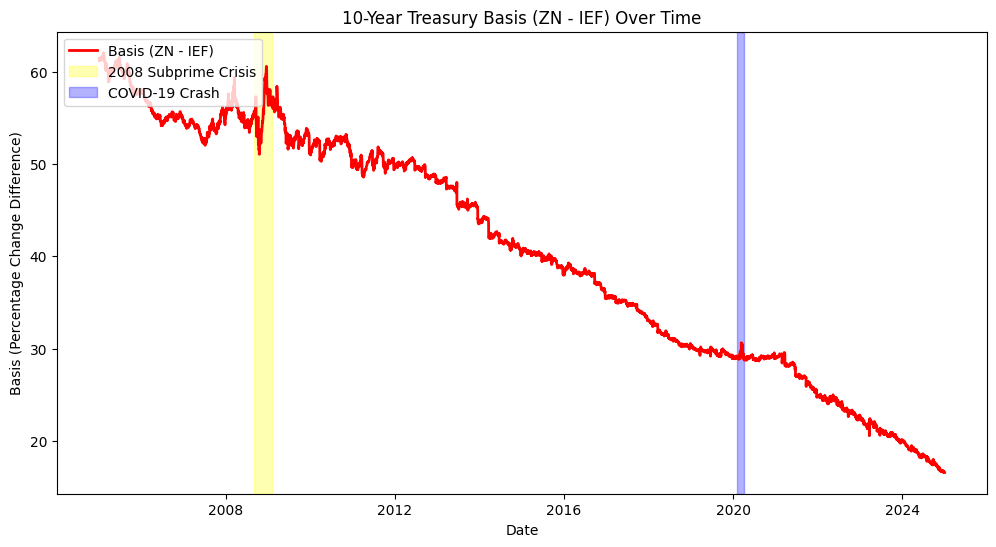

In [41]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download historical data for the 10-year Treasury futures (ZN) and 10-year Treasury bond ETF (IEF)
zn_ticker = 'ZN=F'  # 10-Year Treasury Futures
ief_ticker = 'IEF'  # 7-10 Year Treasury Bond ETF

# Define the date range for historical data
start_date = '2005-01-01'
end_date = '2025-01-01'

# Download the data from Yahoo Finance
zn_data = yf.download(zn_ticker, start=start_date, end=end_date)['Close']
ief_data = yf.download(ief_ticker, start=start_date, end=end_date)['Close']

# Drop any rows with missing data in both datasets to ensure alignment
data = pd.concat([zn_data, ief_data], axis=1).dropna()
data.columns = ['ZN', 'IEF']

# Calculate the basis: the difference between the futures and the bond ETF
basis = data['ZN'] - data['IEF']

# Plot the 10-year Treasury Basis over time
plt.figure(figsize=(12, 6))
plt.plot(basis, label='Basis (ZN - IEF)', color='red', linewidth=2)

# Highlight the 2008 Subprime Crisis (approx. Sept 2008 - Jan 2009)
plt.axvspan('2008-09-01', '2009-01-31', color='yellow', alpha=0.3, label='2008 Subprime Crisis')

# Highlight the COVID-19 Crash (approx. Feb 2020 - Mar 2020)
plt.axvspan('2020-02-01', '2020-03-31', color='blue', alpha=0.3, label='COVID-19 Crash')

# Add labels and title
plt.title('10-Year Treasury Basis (ZN - IEF) Over Time')
plt.xlabel('Date')
plt.ylabel('Basis (Percentage Change Difference)')
plt.legend(loc='upper left')

# Show the plot
plt.show()


In [46]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Download historical data for the 10-year Treasury futures (ZN) and 10-year Treasury bond ETF (IEF)
zn_ticker = 'ZN=F'  # 10-Year Treasury Futures
ief_ticker = 'IEF'  # 7-10 Year Treasury Bond ETF

# Define the date range for historical data
start_date = '2005-01-01'
end_date = '2025-01-01'

# Download the data from Yahoo Finance
zn_data = yf.download(zn_ticker, start=start_date, end=end_date)['Close']
ief_data = yf.download(ief_ticker, start=start_date, end=end_date)['Close']

# Drop any rows with missing data in both datasets to ensure alignment
data = pd.concat([zn_data, ief_data], axis=1).dropna()
data.columns = ['ZN', 'IEF']

# Normalize the 10-year Treasury Futures (ZN) price by dividing by 10
normalized_zn = data['ZN'] / 10

# Calculate the basis: the difference between the normalized futures and the bond ETF
basis = normalized_zn - data['IEF']

# Create a 3D scatter plot using Plotly with balanced size
fig = go.Figure(data=[go.Scatter3d(
    x=normalized_zn,  # X-axis: Normalized Treasury Futures (ZN)
    y=data['IEF'],    # Y-axis: Treasury Bond ETF (IEF)
    z=basis,          # Z-axis: Basis (Difference)
    mode='markers',
    marker=dict(size=3, color=basis, colorscale='Viridis', opacity=0.8)
)])

# Set titles and labels
fig.update_layout(
    title='Relationship Between 10-Year Treasury Futures and Bond ETF',
    scene=dict(
        xaxis_title='Normalized 10-Year Treasury Futures (ZN)',
        yaxis_title='10-Year Treasury Bond ETF (IEF)',
        zaxis_title='Basis (Percentage Change Difference)'
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=1500,  # Balanced width
    height=1000   # Balanced height
)

# Show the interactive 3D plot
fig.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
